<a href="https://colab.research.google.com/github/swagatmitra-b/DataScienceStuff/blob/main/Hostel_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel("./3rd year boys.xlsx")

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

class FixColumns(BaseEstimator, TransformerMixin):

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.copy()
    cols = x.columns.tolist()
    cols_renames = ["Series", "Name", "Branch", "Gender", "Scholar_ID_2", "CGPA", "Hostel"]

    x.rename(columns={p: cols_renames[i] for i, p in enumerate(cols)}, inplace=True)

    x.drop(0, inplace=True)
    x.drop(["Name", "Gender", "Scholar_ID_2", "Series"], axis=1, inplace=True)
    x.dropna(inplace=True)
    x["Branch"] = x.Branch.apply(lambda x: str(x)[:4])
    return x


In [72]:
class CleanData(BaseEstimator, TransformerMixin):

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.copy()
    a = x[x["Branch"] == "2013"]
    x.drop(a.index, inplace=True)
    x = x.reset_index(drop=True)
    return x

In [60]:
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline([
    ('fixcols', FixColumns()),
    ('clean_data', CleanData())
])

In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

class Encode(BaseEstimator, TransformerMixin):

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.copy()

    encode_transformer = ColumnTransformer([
    ('one_h', OneHotEncoder(), ["Branch"]),
    ('ord', OrdinalEncoder(categories=[["BH9A", "BH6", "BH7"]]), ["Hostel"])
    ])

    b = encode_transformer.fit_transform(x)

    feature_names = encode_transformer.get_feature_names_out()


    return pd.concat([x, pd.DataFrame(b.toarray(), columns=feature_names)], axis=1).drop(["Branch", "Hostel"], axis=1).copy()


In [74]:
preprocess = Pipeline([
    ('data_pipeline', data_pipeline),
    ('column_transform', Encode()),
])

data = preprocess.fit_transform(data)
data

,CGPA,one_h__Branch_2211,one_h__Branch_2212,one_h__Branch_2213,one_h__Branch_2214,one_h__Branch_2215,one_h__Branch_2216,ord__Hostel
0,9.57,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.42,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,9.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
677,2.38,0.0,0.0,0.0,1.0,0.0,0.0,2.0
678,2.23,0.0,0.0,0.0,0.0,0.0,1.0,2.0
679,1.54,0.0,1.0,0.0,0.0,0.0,0.0,2.0
680,1.48,0.0,0.0,1.0,0.0,0.0,0.0,2.0


In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

stdScaler = StandardScaler()

x = data.drop("ord__Hostel", axis=1)
y = data["ord__Hostel"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

x_train_scaled = stdScaler.fit_transform(x_train)
x_test_scaled = stdScaler.transform(x_test)

In [76]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()

logReg.fit(x_train_scaled, y_train)

y_pred = logReg.predict(x_test_scaled)

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        59
         1.0       0.98      0.93      0.95        44
         2.0       0.97      0.97      0.97        34

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [78]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[59  0  0]
 [ 2 41  1]
 [ 0  1 33]]


Text(0.5, 1.0, 'Hostel vs CGPA')

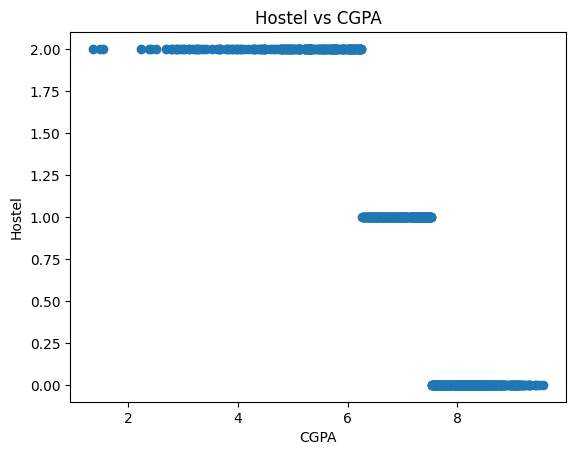

In [79]:
plt.scatter(data["CGPA"], data["ord__Hostel"])
plt.xlabel("CGPA")
plt.ylabel("Hostel")
plt.title("Hostel vs CGPA")